# 835 Final Project

In [12]:
!wget https://raw.githubusercontent.com/HobbitLong/SupContrast/refs/heads/master/losses.py

--2024-12-05 12:57:33--  https://raw.githubusercontent.com/HobbitLong/SupContrast/refs/heads/master/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4137 (4.0K) [text/plain]
Saving to: ‘losses.py.1’

losses.py.1         100%[===================>]   4.04K  --.-KB/s    in 0s      

2024-12-05 12:57:34 (28.6 MB/s) - ‘losses.py.1’ saved [4137/4137]



In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as vF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
from torchvision.models import mobilenet_v2, mobilenet_v3_large, vgg19, vgg16, resnet50, resnet18
from timm.models.swin_transformer import SwinTransformer
from sklearn.linear_model import LinearRegression
import kagglehub
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from losses import SupConLoss
from torch.nn import TripletMarginLoss
import random
from Utils import GetDataset, resnet18_model_runner_get_basic_models, PairDet

c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model
Model architecture based on TractoSCR

### Model training

In [63]:
class SupConModel(nn.Module):
  def __init__(self, feature_dim : int = 128, device : str = "cpu")->None:
    super(SupConModel, self).__init__()
    self.backbone = resnet18(pretrained=True)
    self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.backbone.fc    = nn.Identity()
    self.linear = nn.Linear(512, feature_dim)
    self.encoder = nn.Sequential(
      self.backbone,
      self.linear
    ).to(device)

  def forward(self, X):
    X = self.encoder(X)
    X = F.normalize(X, dim=1)
    return X

# Hyperparameters
batch_size  = 128
epochs      = 100
lr          = 1e-3
split_ratio = 0.9   # %
device      = "cuda:0"
features_dim = 2

sz = (126, 126)
dataset = GetDataset(data_augmentation=True, n_views=2)

# Get the total size of the dataset
dataset_size = len(dataset)

# Calculate sizes for training and validation splits
train_size = int(split_ratio * dataset_size)
val_size = dataset_size - train_size

# Perform the split
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
val_loader   = DataLoader(val_dataset  , batch_size=batch_size, shuffle=False)

supconmodel = SupConModel(features_dim, device)
optimizer   = torch.optim.Adam(supconmodel.parameters(), lr=lr, weight_decay=1e-5)
pdr         = PairDet(threshold = 1)
lossfn      = SupConLoss(base_temperature=0.001, temperature=0.01)

total_losses = []
for epoch in range(epochs):
  supconmodel.train()
  print(f'########################################')
  print(f'Epoch: {epoch+1}')

  losses = 0
  count  = 0
  for images, temperatures in train_loader:
    N      = images.shape[0]
    V      = images.shape[1]
    images = images.reshape(N * V, 1, sz[0], sz[1])
    temperatures = temperatures.unsqueeze(1).expand(-1, V).reshape(N * V, 1)
    ##
    ##
    ##
    pairs = pdr(temperatures).float() - torch.eye(N * V, N * V, device=device).float()
    proj  = supconmodel(images).unsqueeze(1).to(device)
    loss  = lossfn(proj, mask=pairs)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses += loss.cpu().detach().numpy()
    count  += 1
    print(f'*', end='')
  print('\n')
  print(f'Loss: {losses / count}')
  total_losses.append(losses / count)
total_losses = np.array(total_losses).squeeze()

Path to dataset files: C:\Users\tsope\.cache\kagglehub\datasets\juanda220485\synthetic-dataset-of-speckle-images\versions\1


c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


########################################
Epoch: 1
*****

Loss: 510.6541488647461
########################################
Epoch: 2
*****

Loss: 90.96098480224609
########################################
Epoch: 3
*****

Loss: 54.50245361328125
########################################
Epoch: 4
*****

Loss: 52.495750427246094
########################################
Epoch: 5
*****

Loss: 52.420283508300784
########################################
Epoch: 6
*****

Loss: 52.23059844970703
########################################
Epoch: 7
*****

Loss: 52.16499481201172
########################################
Epoch: 8
*****

Loss: 51.913560485839845
########################################
Epoch: 9
*****

Loss: 51.729513549804686
########################################
Epoch: 10
*****

Loss: 51.24538345336914
########################################
Epoch: 11
*****

Loss: 50.559583282470705
########################################
Epoch: 12
*****

Loss: 48.81163864135742
####################

### Visualize encoding space

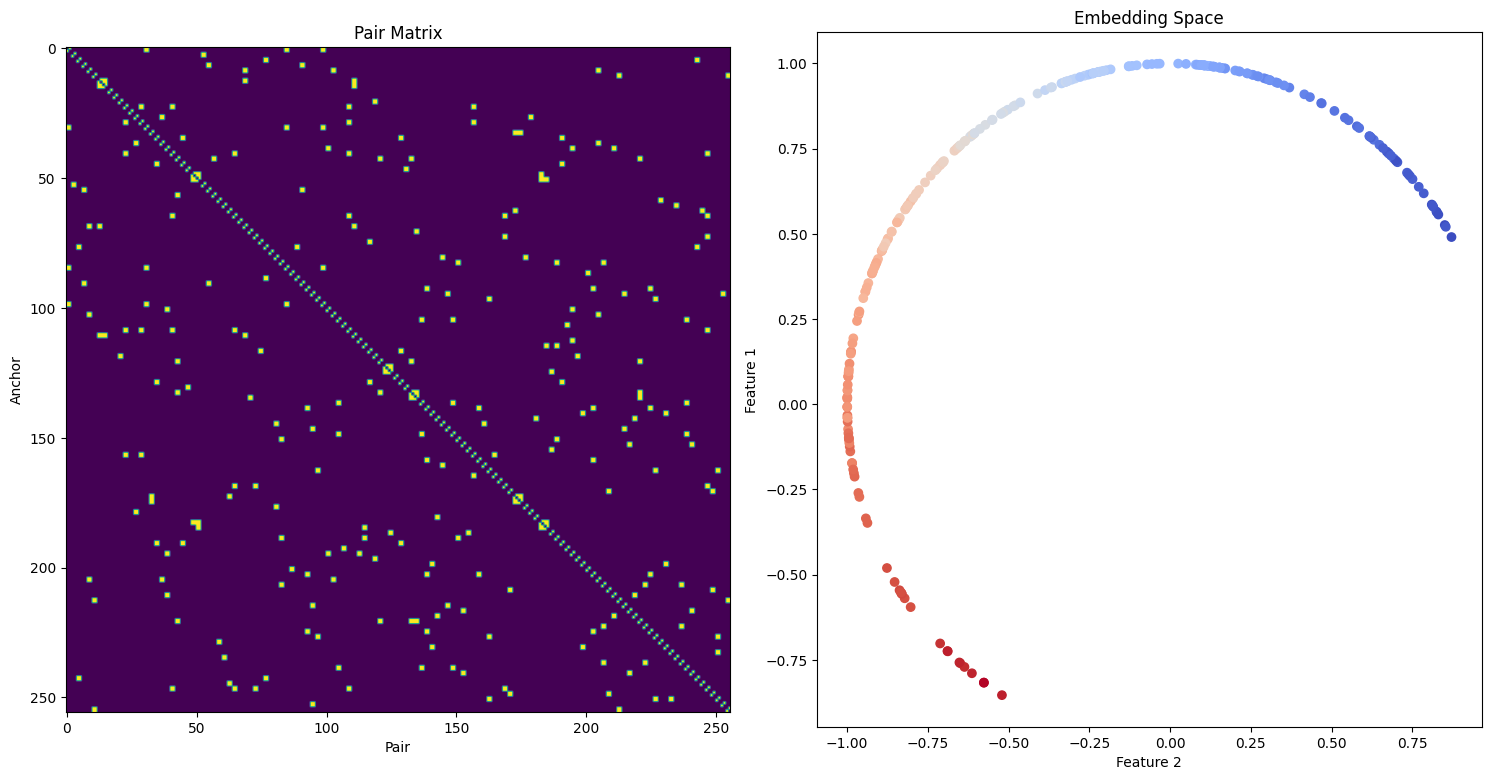

In [70]:
supconmodel.eval()
with torch.no_grad():
    # extract 1 batch of images and temperature
    for images, temperatures in train_loader:
        break

    N      = images.shape[0]
    V      = images.shape[1]
    images = images.reshape(N * V, 1, sz[0], sz[1])
    temperatures = temperatures.unsqueeze(1).expand(-1, V).reshape(N * V, 1)
    proj  = supconmodel(images).unsqueeze(1)
    pairs = pdr(temperatures).float() - torch.eye(N * V, N * V, device=device).float()
    proj  = proj.cpu().detach().numpy().squeeze()

    plt.figure(figsize=[15, 15])
    plt.subplot(2,2,1)
    plt.imshow(pairs.cpu().detach().numpy())
    plt.title("Pair Matrix")
    plt.xlabel("Pair")
    plt.ylabel("Anchor")

    plt.subplot(2,2,2)
    plt.scatter(proj[:,0], proj[:,1], c=temperatures.cpu().detach().numpy().flatten(), cmap='coolwarm')
    plt.title("Embedding Space")
    plt.xlabel("Feature 2")
    plt.ylabel("Feature 1")

    plt.tight_layout()
    plt.savefig('resnet18_2_embedding.png')
    plt.show()